Imports

In [17]:
from modAL import batch, uncertainty, density, utils, disagreement
from modAL.models import ActiveLearner, Committee
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets, svm, metrics, tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics.pairwise import paired_distances
import numpy as np
from functools import partial
from typing import Union, Tuple
import pandas as pd
from art.attacks.evasion import FastGradientMethod, DeepFool
from art.estimators.classification.scikitlearn import SklearnClassifier
from copy import deepcopy
from importlib import reload
from tqdm.notebook  import tqdm, trange
from joblib import Parallel, delayed
from celluloid import Camera
from IPython.core.display import HTML, display
import warnings


# IMITATE
# Ideally would be in a subdirectory but not supported by ipynb, see importnb for a better replacement.
from ipynb.fs.defs import Bias
from ipynb.fs.defs.Datasets import generateData_twoPills_2D, generateData_twoPills_noNoise_2D, plot_dataset_2D

from libadversarial import random_batch, uncertainty_id, fgm, deepfool
from libplot import plot_classification
from libutil import ProgressParallel
from libactive import MyActiveLearner, active_learn, active_learn2, active_split

## Experiment 1

* 1000 points
* With Noise
* Bias angle $\frac{\pi}{4}$
* labeled_size $0.1$

In [18]:
X, y = generateData_twoPills_2D(1000)

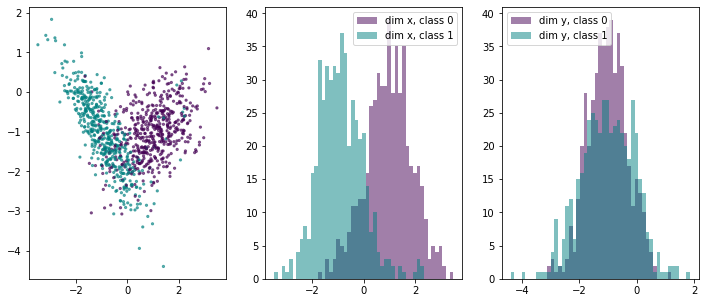

In [21]:
plot_dataset_2D(X[:,(0,1)], y)

In [5]:
X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.2)

In [6]:
X_biased, y_biased = Bias.bias_rotate_2D(X_labelled, y_labelled, alpha=0.25*np.pi, biasedClass=0, prob=0)

c:\users\zac\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


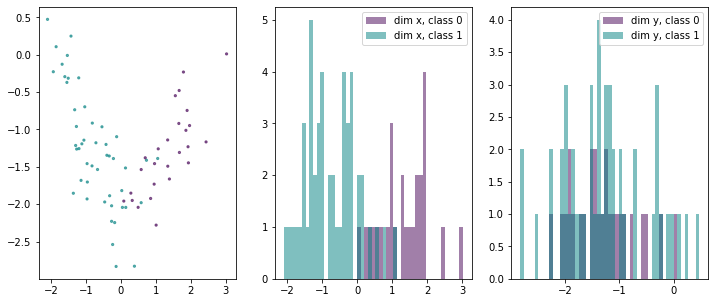

In [41]:
plot_dataset_2D(X_biased[:,(0,1)], y_biased)

In [83]:
query_methods = {
    "random": random_batch,
    "uncertainty": batch.uncertainty_batch_sampling,
    "uncertainty_id": uncertainty_id,
    "fgm": fgm,
    "deepfool": deepfool
}

DeepFool: 100%|██████████████████████████████| 10/10 [00:01<00:00,  6.56it/s]


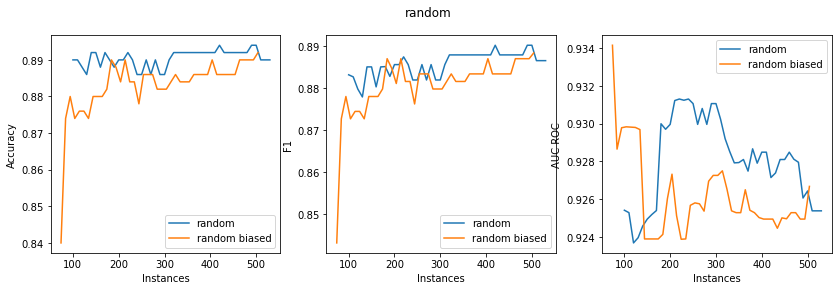

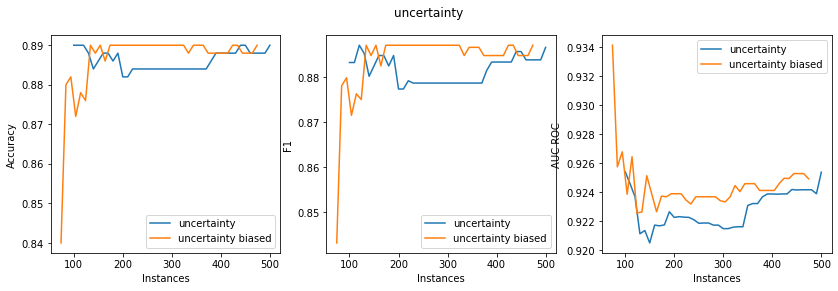

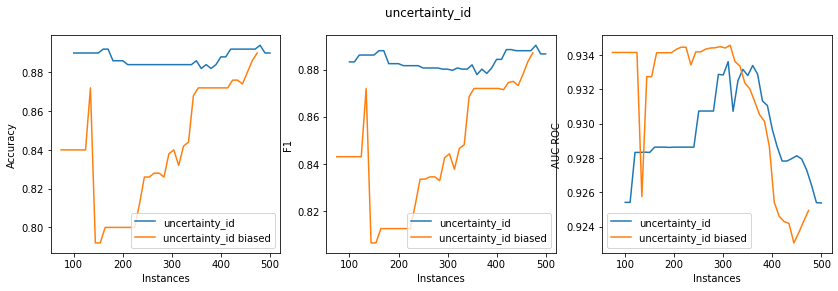

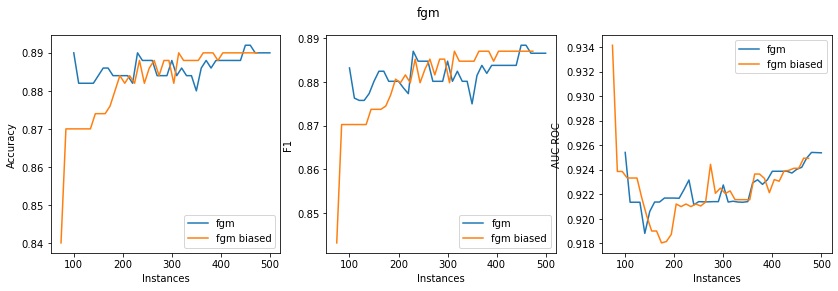

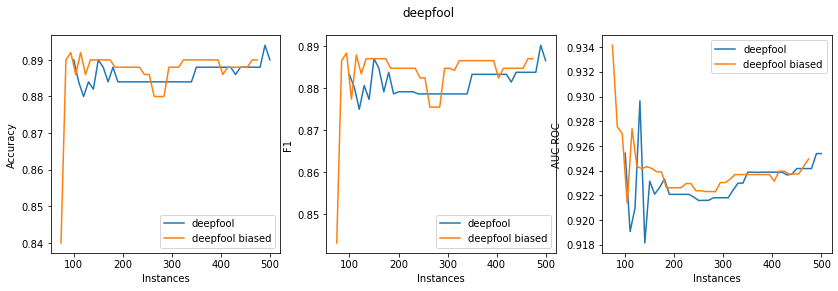

In [84]:
for name, method in query_methods.items():
    results = active_learn(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, partial(method, n_instances=10))
    biased_results = active_learn(X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, partial(method, n_instances=10))
    fig, axes = plt.subplots(1, 3, figsize=(14,4))
    for i, ax in enumerate(axes.flatten()):
        ax.plot(results[0], results[1+i], label=name);
        ax.plot(biased_results[0], biased_results[1+i], label=f"{name} biased")
        ax.legend(); ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC"][i]); fig.suptitle(name)

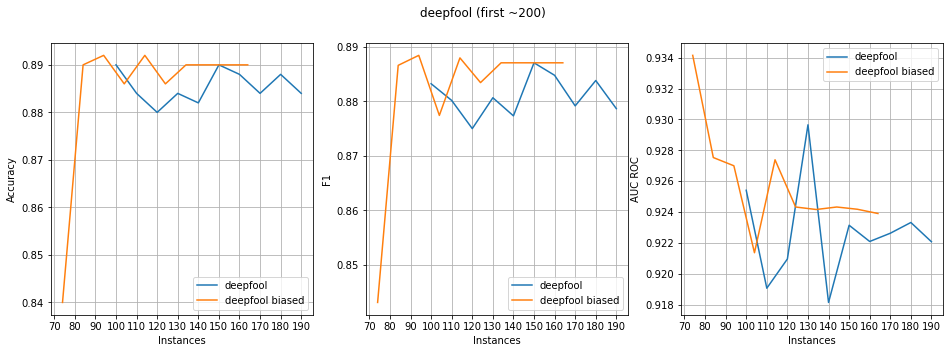

In [98]:
fig, axes = plt.subplots(1, 3, figsize=(16,5))
for i, ax in enumerate(axes.flatten()):
    ax.plot(results[0][:10], results[1+i][:10], label=name);
    ax.plot(biased_results[0][:10], biased_results[1+i][:10], label=f"{name} biased")
    ax.legend(); ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC"][i]); fig.suptitle(f"{name} (first ~200)"); ax.grid();
    ax.set_xticks(np.arange(70, 200, 10))

## Experiment 2

* 1000 points
* With Noise
* Bias angle $\frac{\pi}{4}$
* labeled_size $0.3$

In [101]:
X, y = generateData_twoPills_2D(1000)

c:\users\zac\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


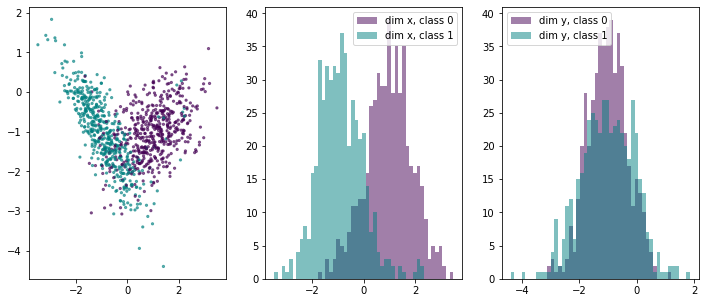

In [102]:
plot_dataset_2D(X[:,(0,1)], y)

In [103]:
X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.3)

In [104]:
X_biased, y_biased = Bias.bias_rotate_2D(X_labelled, y_labelled, alpha=0.25*np.pi, biasedClass=0, prob=0)

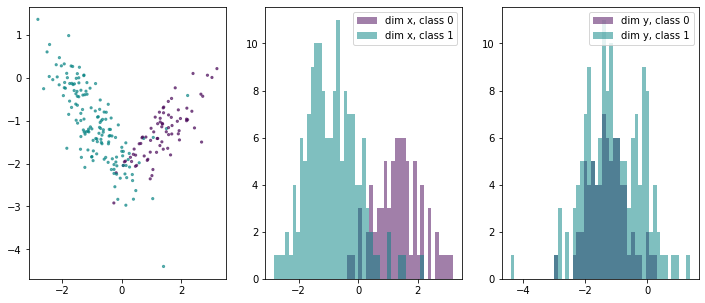

In [105]:
plot_dataset_2D(X_biased[:,(0,1)], y_biased)

In [143]:
query_methods = {
    "random": random_batch,
    "uncertainty": batch.uncertainty_batch_sampling,
    "uncertainty_id": uncertainty_id,
    "fgm": fgm,
    # deepfool is **slow**
    #"deepfool": deepfool
}

Comparison with unbiased.

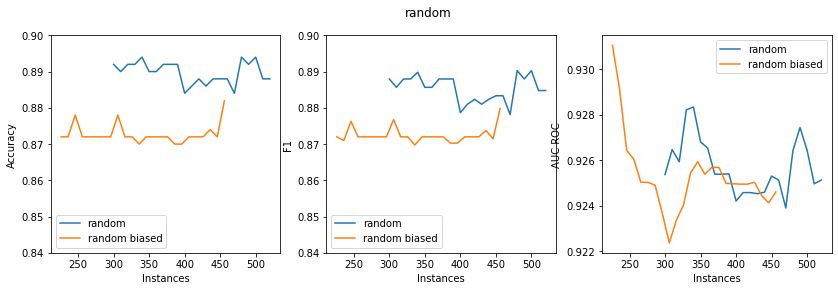

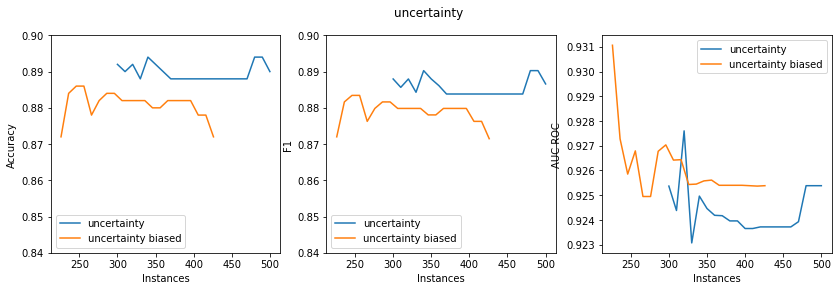

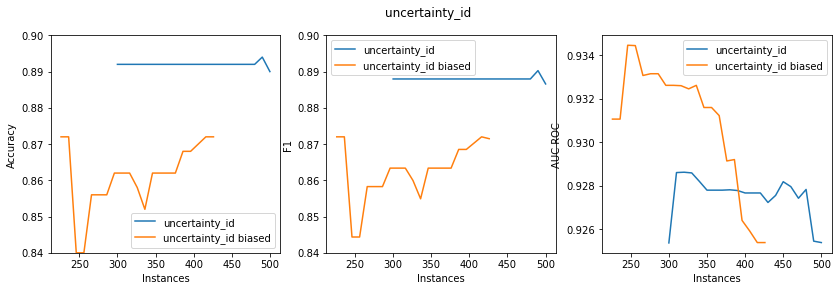

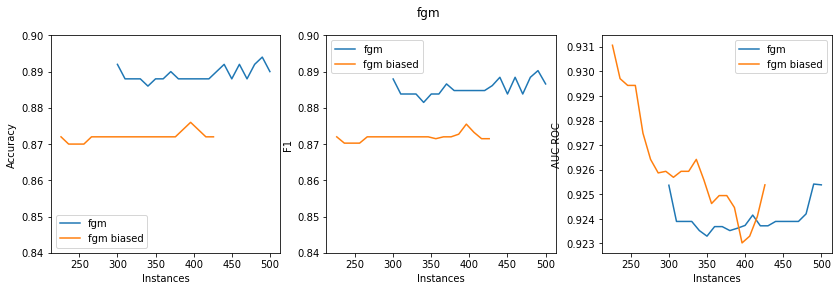

In [110]:
for name, method in query_methods.items():
    results = active_learn(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, partial(method, n_instances=10))
    biased_results = active_learn(X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, partial(method, n_instances=10))
    fig, axes = plt.subplots(1, 3, figsize=(14,4))
    for i, ax in enumerate(axes.flatten()):
        ax.plot(results[0], results[1+i], label=name);
        ax.plot(biased_results[0], biased_results[1+i], label=f"{name} biased")
        ax.legend(); ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC"][i]); fig.suptitle(name);
        if i != 2:
            ax.set_ylim(0.84, 0.9)

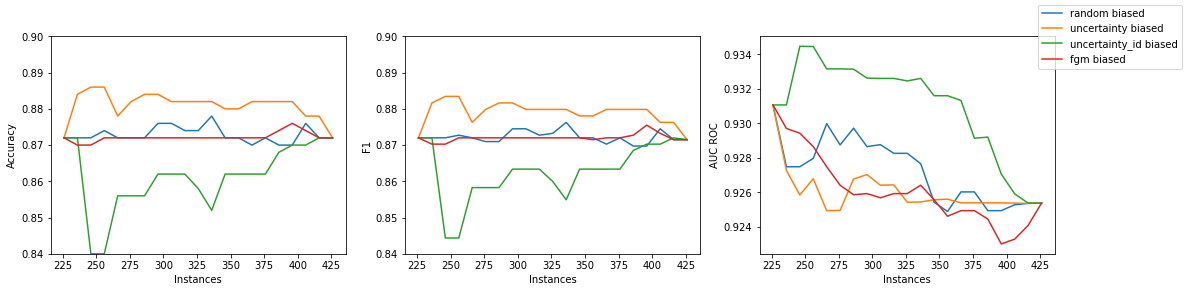

In [142]:
fig, axes = plt.subplots(1, 3, figsize=(18,4))
for name, method in query_methods.items():
    #results = active_learn(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, partial(method, n_instances=10))
    biased_results = active_learn(X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, partial(method, n_instances=10))
    for i, ax in enumerate(axes.flatten()):
        #ax.plot(results[0], results[1+i], label=name  if i == 0 else "");
        ax.plot(biased_results[0], biased_results[1+i], label=f"{name} biased" if i == 0 else "")
        ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC"][i])
        if i != 2:
            ax.set_ylim(0.84, 0.9)
fig.legend();

Notes: Observing the effect we're looking for is a delicate balance. An initial labeled set that is too small means that the bias doesn't weight the overall data to cause enough of a problem. On the other hand using an initially biased set that is too big means that the active learner doesn't really have to do anything (as the decision boundary is already in an approximately correct position).

Perhaps we should be actively trying to find a pathalogically bad case*, as that's really what we want these active learning algorithms to avoid?

\* As could occur if they repeatedly sampled from a single reigon due to bias...

## Main Experiments

Baseline:

* $1000$ points
* Bias angle $\pi$
* Noise
* Labelled set size $0.1$
* Batch size $10$

In [297]:
query_methods = {
    "random": random_batch,
    "uncertainty": batch.uncertainty_batch_sampling,
    "uncertainty_id": uncertainty_id,
    "fgm": fgm,
    # deepfool is **slow**
    "deepfool": deepfool
}

In [284]:
X, y = generateData_twoPills_2D(1000)

In [296]:
df = pd.DataFrame(X)
df.insert(2, 'labels', y)
df.to_csv('Experiments/data.csv')

## Bias Angle

<ipython-input-299-d39388b33174>:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


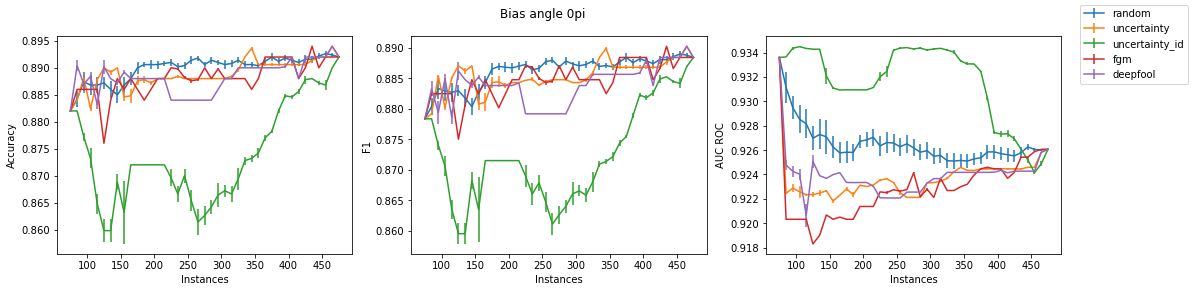

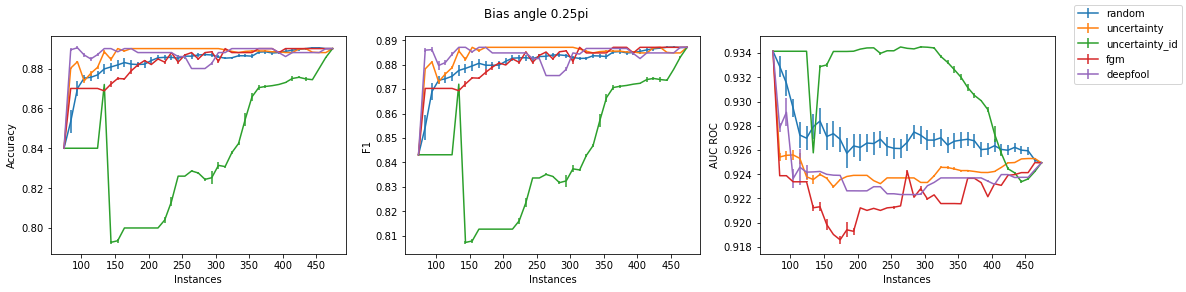

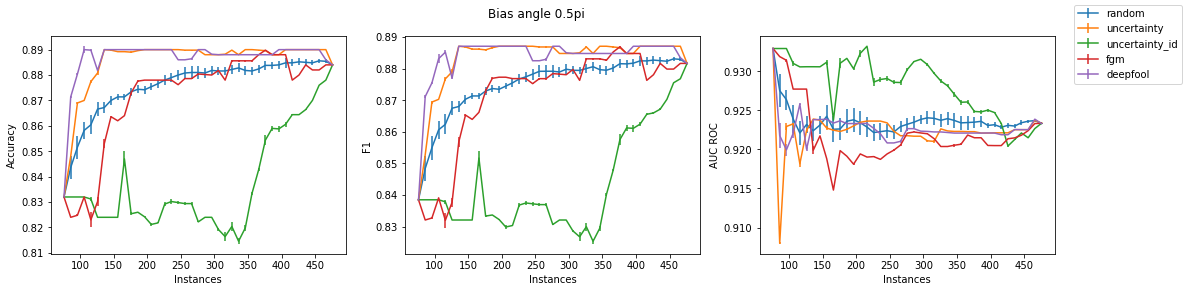

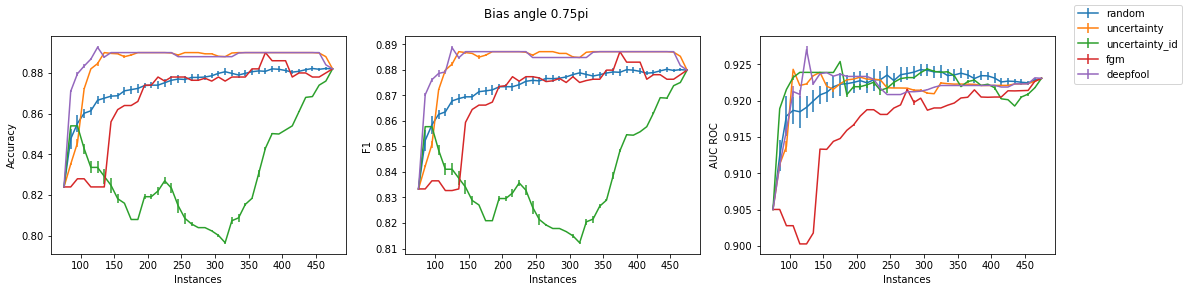

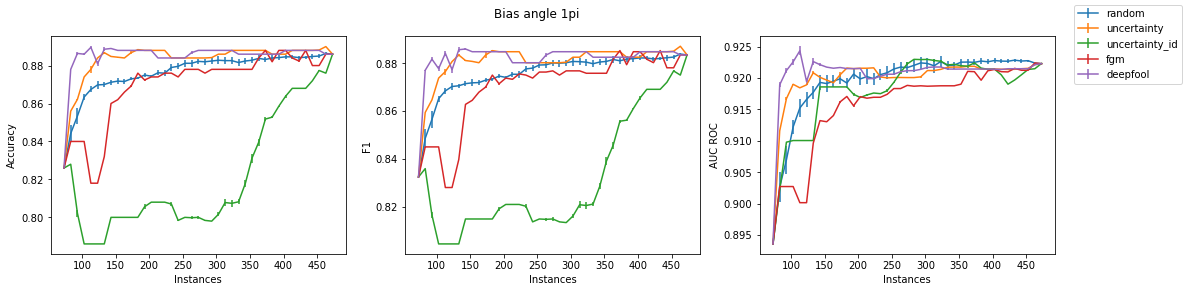

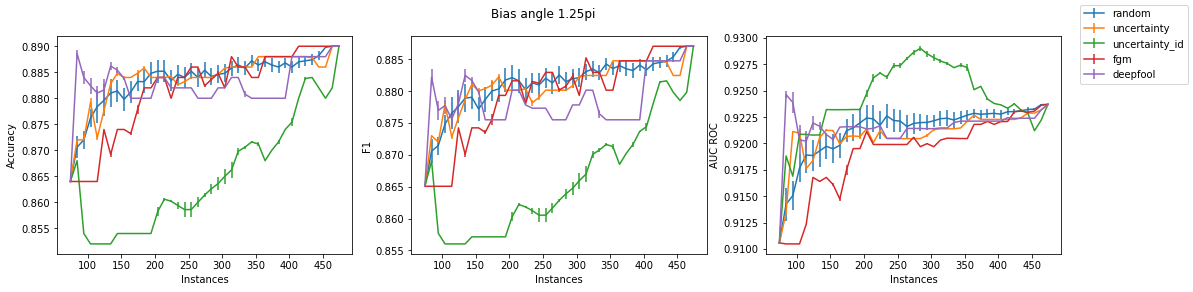

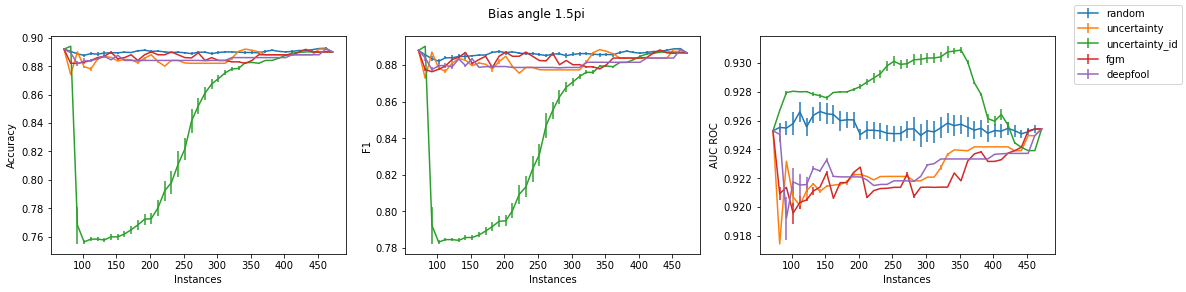

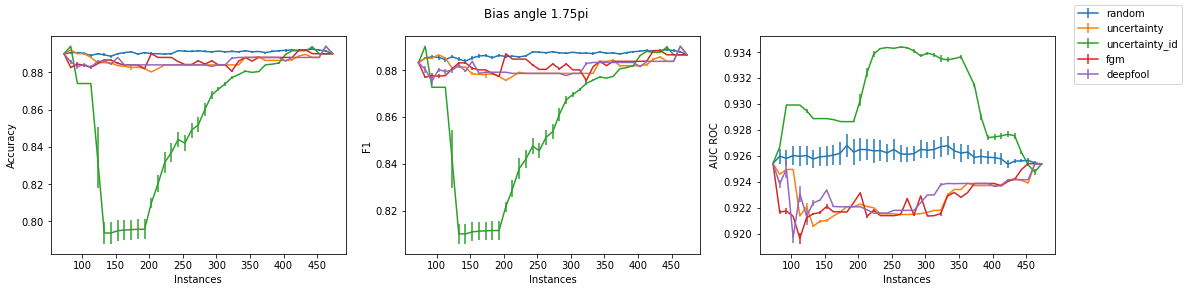

In [299]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.1)

for angle in tqdm([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75], desc="Angle", leave=False):
    X_biased, y_biased = Bias.bias_rotate_2D(X_labelled, y_labelled, alpha=angle*np.pi, biasedClass=0, prob=0)
    
    fig, axes = plt.subplots(1, 3, figsize=(18,4))
    
    for name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
        metrics = ProgressParallel(n_jobs=4, total=10, desc=f"Run", leave=False)(
            delayed(
                active_learn2
            )(X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, partial(method, n_instances=10))
            for _ in range(10)
        )
        metrics, stderr = metrics[0].average(metrics[1:])
        metrics.to_csv(f"Experiments/experiment_angle_{angle}_method_{method.__name__}.csv")
        stderr.to_csv(f"Experiments/experiment_angle_{angle}_method_{method.__name__}_stderr.csv")
        
        for i, ax in enumerate(axes.flatten()):
            ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{name}" if i == 0 else "")
            ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC"][i]); plt.suptitle(f"Bias angle {angle}pi")
            #if i != 2:
                #ax.set_ylim(0.84, 0.9)
                
    fig.legend()
    fig.show();

**Notes**

* What other types of bias could we investigate?
    * Exclusion bias (in the case of categorical variables or clusters)
* I do want to try running Deepfool on more datasets. Usually adversarial learning algorithms trade places quite a bit, I haven't yet seen a case where Deepfool fails.
* Performance of deepfool is an issue, might have to be resolved before doing the above.
* It would be good to try this on real datasets.

## Labelled set size

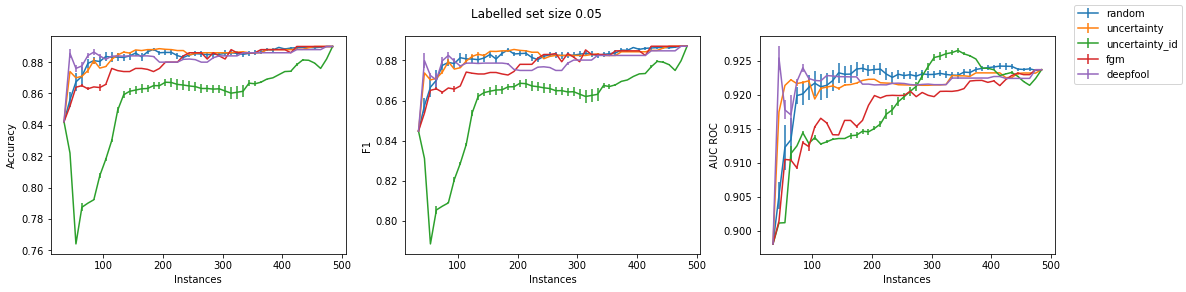

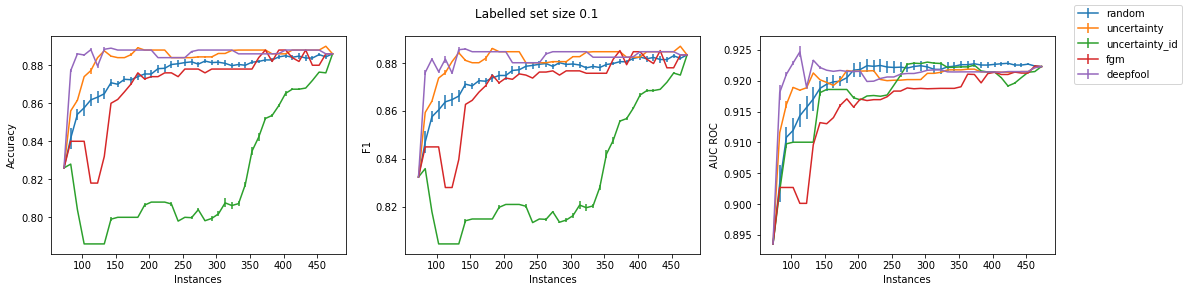

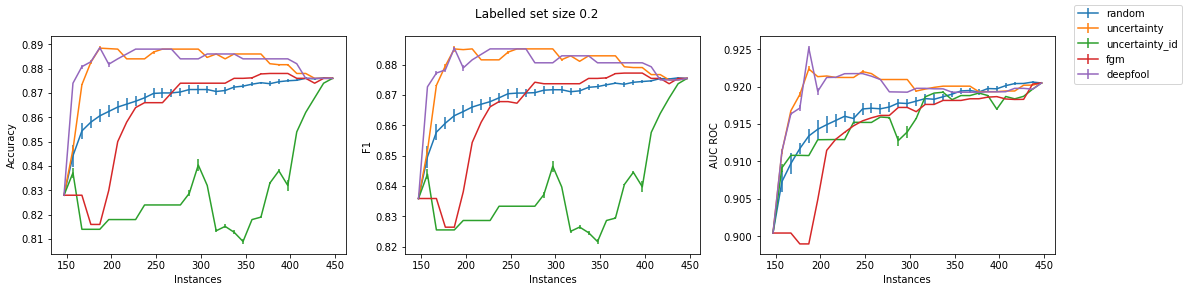

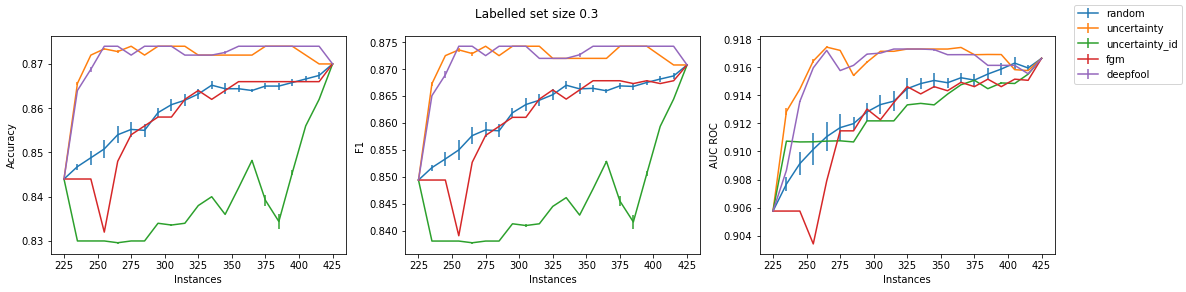

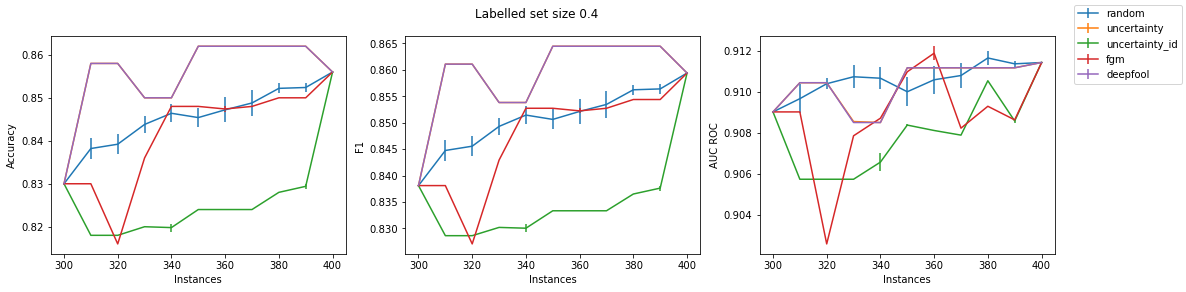

In [300]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

for labelled_size in tqdm([0.05, 0.1, 0.2, 0.3, 0.4], desc="Labelled size", leave=False):
    X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=labelled_size)
    
    X_biased, y_biased = Bias.bias_rotate_2D(X_labelled, y_labelled, alpha=np.pi, biasedClass=0, prob=0)
    
    fig, axes = plt.subplots(1, 3, figsize=(18,4))
    
    for name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
        metrics = ProgressParallel(n_jobs=4, total=10, desc=f"Run", leave=False)(
            delayed(
                active_learn2
            )(X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, partial(method, n_instances=10))
            for _ in range(10)
        )
        metrics, stderr = metrics[0].average(metrics[1:])
        metrics.to_csv(f"Experiments/experiment_labelled_{labelled_size}_method_{method.__name__}.csv")
        stderr.to_csv(f"Experiments/experiment_labelled_{labelled_size}_method_{method.__name__}_stderr.csv")
        
        for i, ax in enumerate(axes.flatten()):
            ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{name}" if i == 0 else "")
            ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC"][i]); plt.suptitle(f"Labelled set size {labelled_size}")
            #if i != 2:
                #ax.set_ylim(0.84, 0.9)
                
    fig.legend();

**Notes**

* With a labelled set size of $0.4$ uncertainty_id was exactly as good as deepfool. 

## Batch size

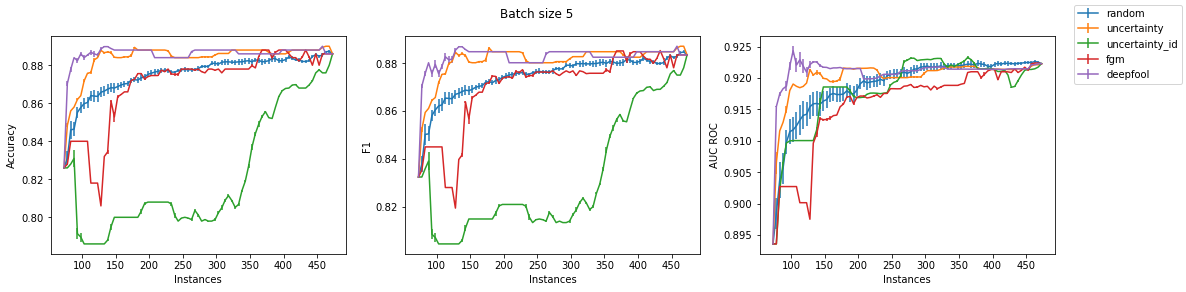

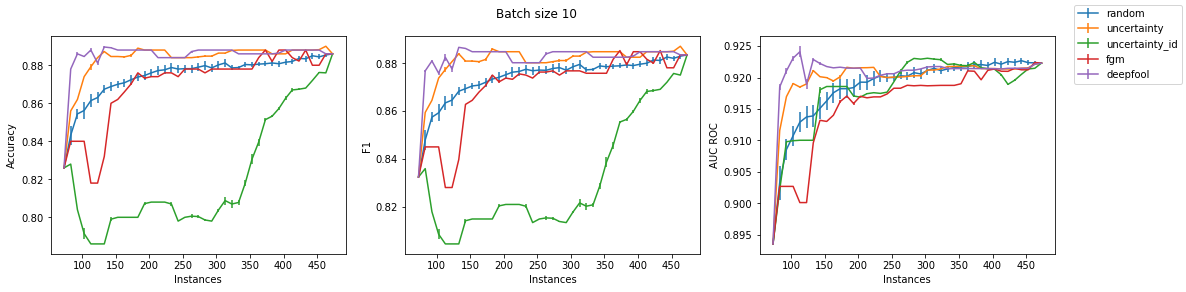

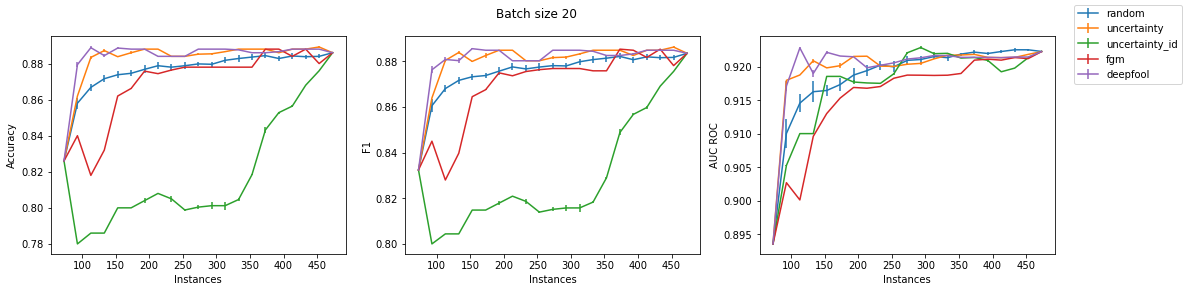

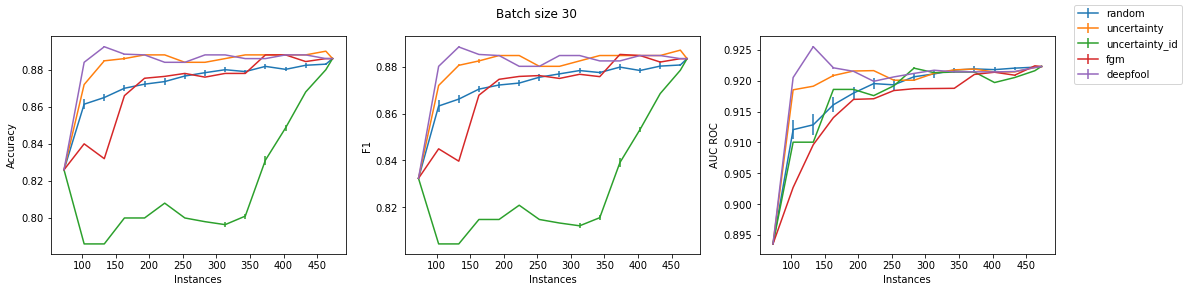

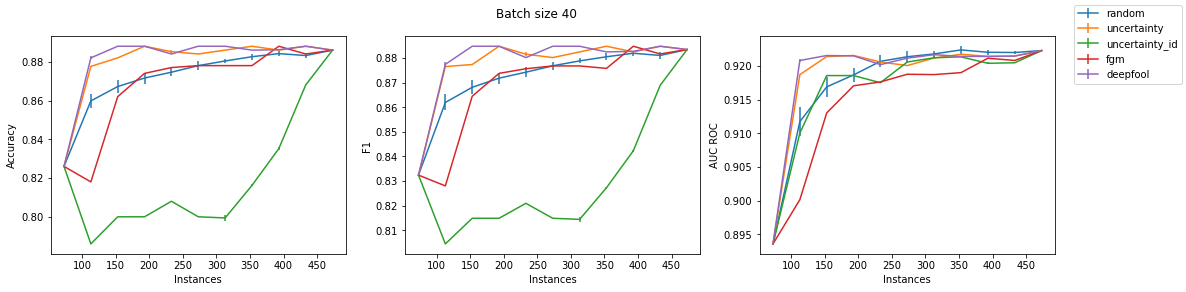

In [301]:
# Annoying hack so that the progressbars disapear as they're supposed to
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

for batch_size in tqdm([5, 10, 20, 30, 40], desc="Batch size", leave=False):
    X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.1)
    
    X_biased, y_biased = Bias.bias_rotate_2D(X_labelled, y_labelled, alpha=np.pi, biasedClass=0, prob=0)
    
    fig, axes = plt.subplots(1, 3, figsize=(18,4))
    
    for name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
        metrics = ProgressParallel(n_jobs=4, total=10, desc=f"Run", leave=False)(
            delayed(
                active_learn2
            )(X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, partial(method, n_instances=batch_size))
            for _ in range(10)
        )

        metrics, stderr = metrics[0].average(metrics[1:])
        metrics.to_csv(f"Experiments/experiment_batch_{batch_size}_method_{method.__name__}.csv")
        stderr.to_csv(f"Experiments/experiment_batch_{batch_size}_method_{method.__name__}_stderr.csv")
        
        for i, ax in enumerate(axes.flatten()):
            ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{name}" if i == 0 else "")
            ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC"][i]); plt.suptitle(f"Batch size {batch_size}")
            #if i != 2:
                #ax.set_ylim(0.84, 0.9)
                
    fig.legend();

## Animations

### Uncertainty with Information Density

Bias angle $\pi$

In [369]:
X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.1)
X_biased, y_biased = Bias.bias_rotate_2D(X_labelled, y_labelled, alpha=np.pi, biasedClass=0, prob=0)
learner = MyActiveLearner(animate=True)
_metrics = learner.active_learn2(X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, partial(uncertainty_id, n_instances=10))

### Uncertainty

Bias angle $\pi$

In [370]:
X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.1)
X_biased, y_biased = Bias.bias_rotate_2D(X_labelled, y_labelled, alpha=np.pi, biasedClass=0, prob=0)
learner = MyActiveLearner(animate=True)
_metrics = learner.active_learn2(X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, partial(batch.uncertainty_batch_sampling, n_instances=10))

### Deepfool

Bias angle $\pi$

In [372]:
# Warnings are:
# * clip_values unspecified: we don't actually care because it doesn't matter if the adversarial example is 'out of bounds'
# * DeepFool expects logits not probabilities, may influence attack strength. Would be good to fix this
# * modAL deprecation warning about query strategy returns (this is intentional, I'm abusing the framework to also return the generated adversarial examples)
warnings.filterwarnings(action='ignore', module='art.attacks.evasion.deepfool')

X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.1)
X_biased, y_biased = Bias.bias_rotate_2D(X_labelled, y_labelled, alpha=np.pi, biasedClass=0, prob=0)
learner = MyActiveLearner(animate=True)
_metrics = learner.active_learn2(X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, partial(deepfool, n_instances=10))

Bias angle $0$ (worst case for deepfool)

In [373]:
# Warnings are:
# * clip_values unspecified: we don't actually care because it doesn't matter if the adversarial example is 'out of bounds'
# * DeepFool expects logits not probabilities, may influence attack strength. Would be good to fix this
# * modAL deprecation warning about query strategy returns (this is intentional, I'm abusing the framework to also return the generated adversarial examples)
warnings.filterwarnings(action='ignore', module='art.attacks.evasion.deepfool')

X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.1)
X_biased, y_biased = Bias.bias_rotate_2D(X_labelled, y_labelled, alpha=0, biasedClass=0, prob=0)
learner = MyActiveLearner(animate=True)
_metrics = learner.active_learn2(X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, partial(deepfool, n_instances=10))

## Double-check ID performs well in unbiased case

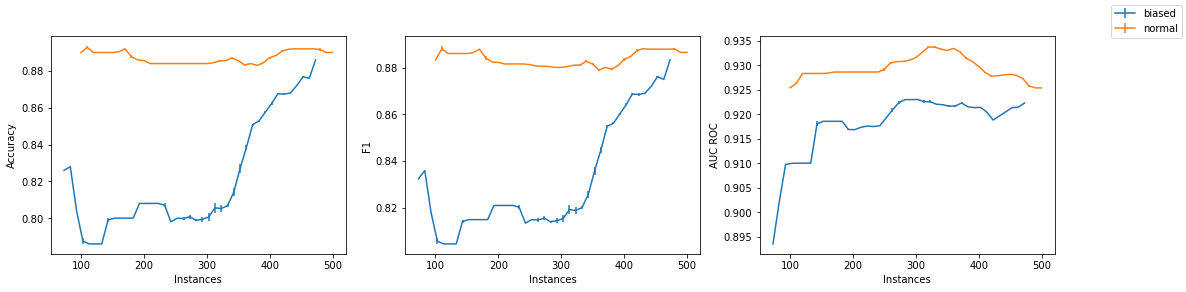

In [379]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.1)

X_biased, y_biased = Bias.bias_rotate_2D(X_labelled, y_labelled, alpha=np.pi, biasedClass=0, prob=0)

fig, axes = plt.subplots(1, 3, figsize=(18,4))

for i, (X_biased, y_biased) in enumerate([(X_biased, y_biased), (X_labelled, y_labelled)]):
    metrics = ProgressParallel(n_jobs=4, total=10, desc=f"Run", leave=False)(
        delayed(
            active_learn2
        )(X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, partial(uncertainty_id, n_instances=10))
        for _ in range(10)
    )
    label = ["biased", "normal"][i]
    metrics, stderr = metrics[0].average(metrics[1:])
    metrics.to_csv(f"Experiments/experiment_uncertainty_id_{label}.csv")
    stderr.to_csv(f"Experiments/experiment_uncertainty_id_{label}_stderr.csv")

    for i, ax in enumerate(axes.flatten()):
        ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{label}" if i == 0 else "")
        ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC"][i])
        #if i != 2:
            #ax.set_ylim(0.84, 0.9)

fig.legend()
fig.show();

In [380]:
query_methods = {
    "random": random_batch,
    "uncertainty": batch.uncertainty_batch_sampling,
    "uncertainty_id": uncertainty_id,
    "fgm": fgm,
    # deepfool is **slow**
    #"deepfool": deepfool
}

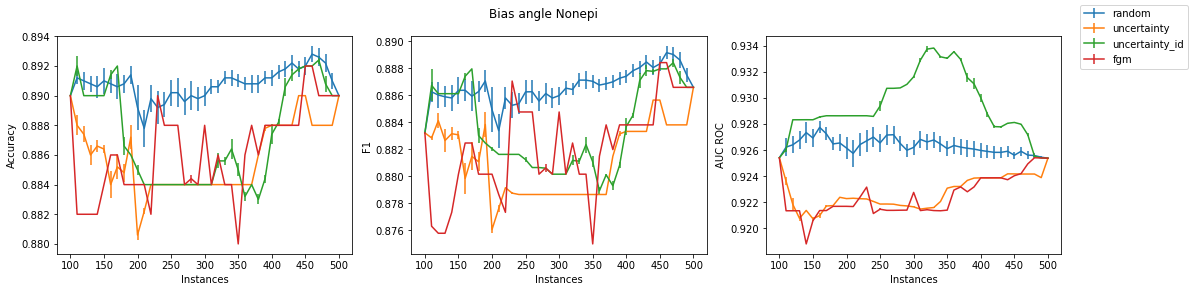

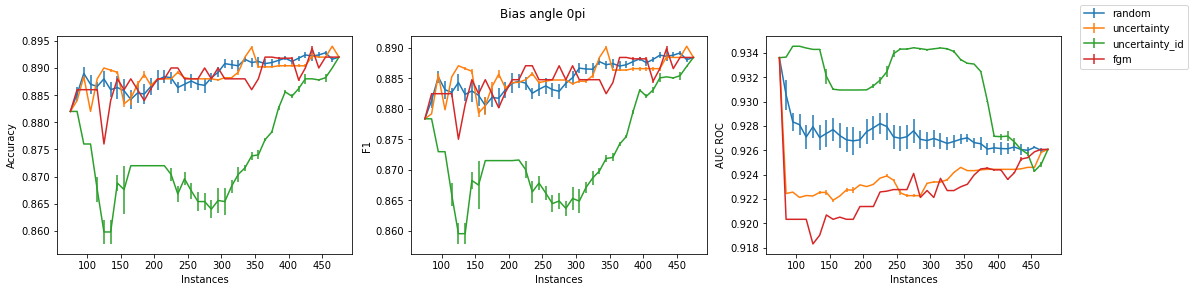

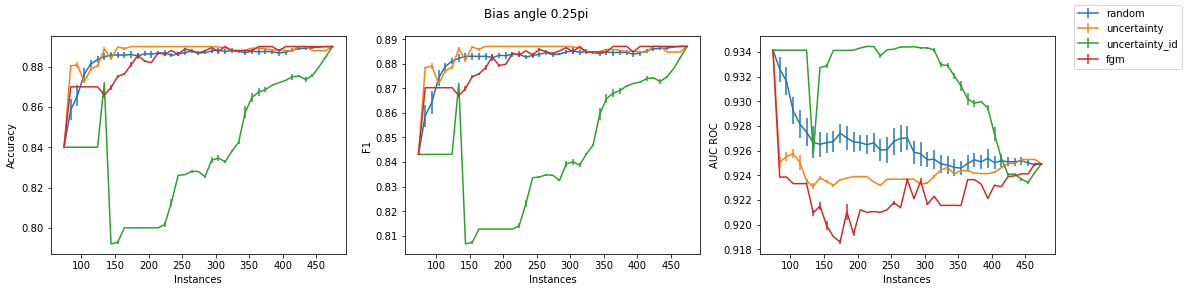

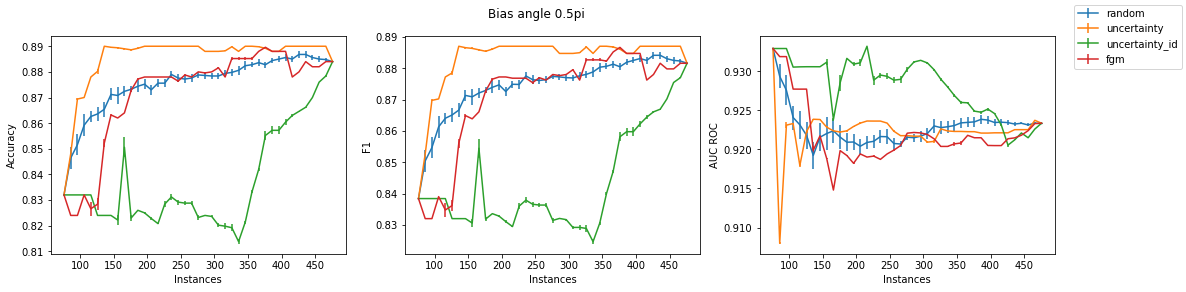

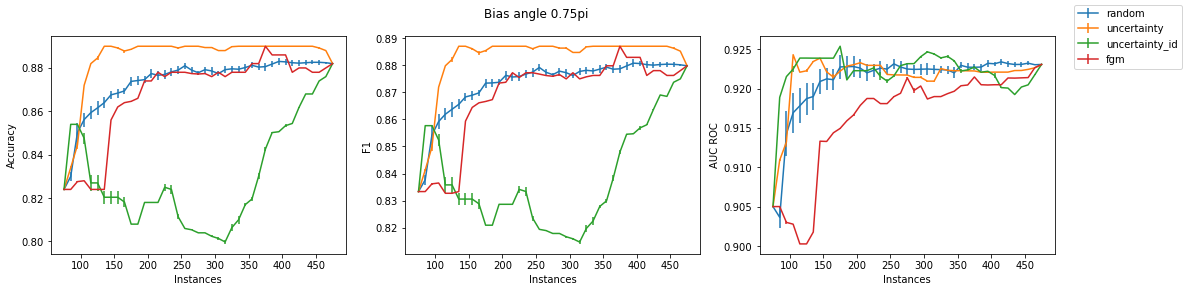

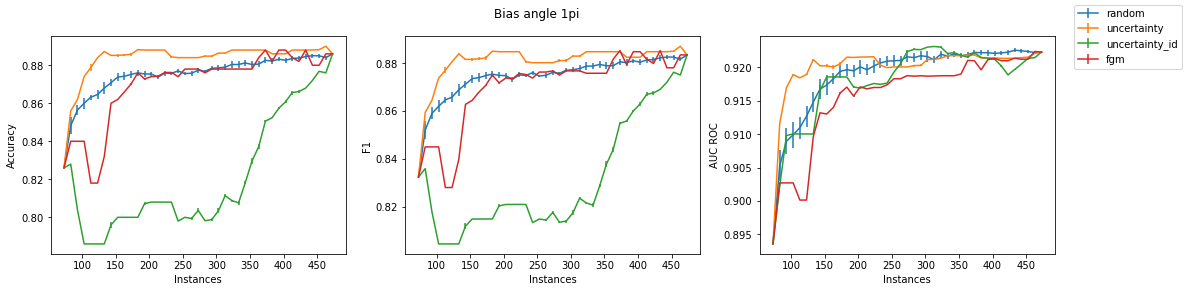

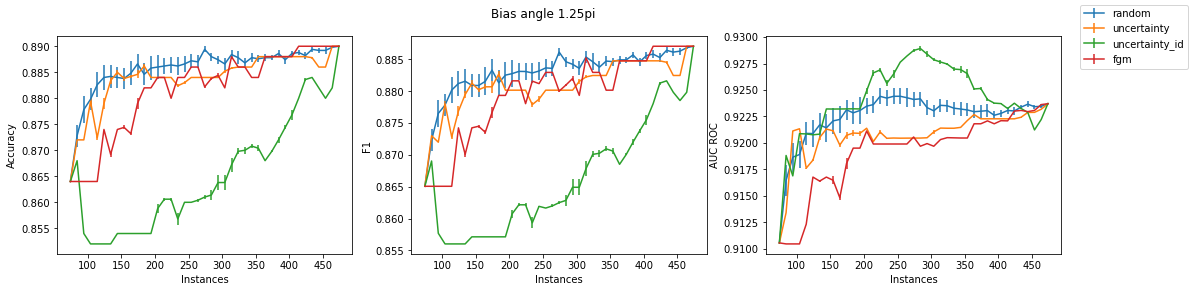

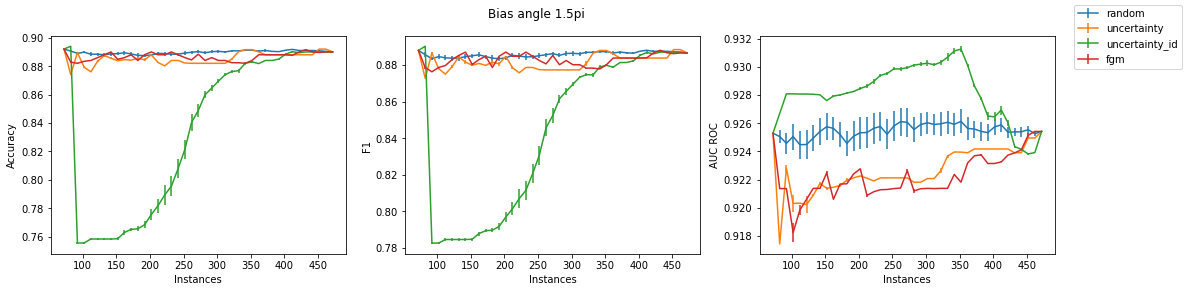

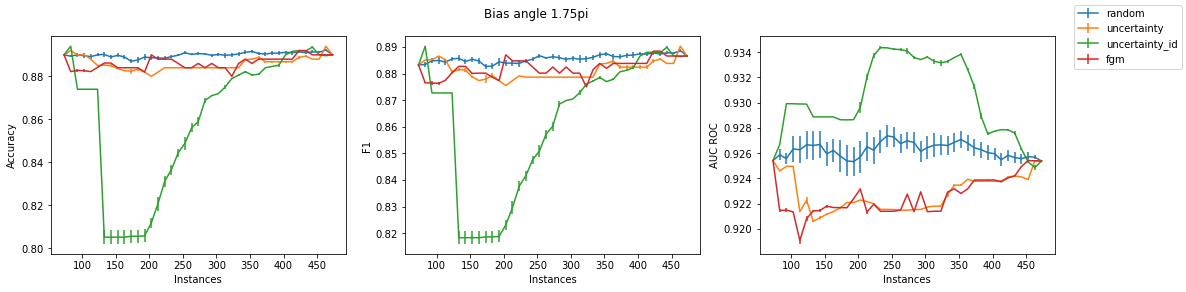

In [388]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.1)

for angle in tqdm([None, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75], desc="Angle", leave=False):
    if angle is not None:
        X_biased, y_biased = Bias.bias_rotate_2D(X_labelled, y_labelled, alpha=angle*np.pi, biasedClass=0, prob=0)
    else:
        X_biased, y_biased = X_labelled, y_labelled

    fig, axes = plt.subplots(1, 3, figsize=(18,4))
    
    for name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
        metrics = ProgressParallel(n_jobs=4, total=10, desc=f"Run", leave=False)(
            delayed(
                active_learn2
            )(X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, partial(method, n_instances=10))
            for _ in range(10)
        )
        metrics, stderr = metrics[0].average(metrics[1:])
        #metrics.to_csv(f"Experiments/experiment_angle_{angle}_method_{method.__name__}.csv")
        #stderr.to_csv(f"Experiments/experiment_angle_{angle}_method_{method.__name__}_stderr.csv")
        
        for i, ax in enumerate(axes.flatten()):
            ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{name}" if i == 0 else "")
            ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC"][i]); plt.suptitle(f"Bias angle {angle}pi" if angle is not None else "Unbiased")
            #if i != 2:
                #ax.set_ylim(0.84, 0.9)
                
    fig.legend()
    fig.show();

In [15]:
import libadversarial; reload(libadversarial); from libadversarial import uncertainty_id
active_learn2(X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, partial(uncertainty_id, n_instances=10))

uncertainty 1.0848931752960311e-09-0.5 id 0.21556710551366545-0.4638566797526327


ValueError: Expected 2D array, got 1D array instead:
array=[7.01144125e-03 3.91747852e-03 2.97216016e-01 8.96117338e-04
 2.19755253e-01 6.39511580e-03 1.72348949e-07 4.89901114e-08
 1.69049033e-02 1.29225054e-02 4.42186193e-06 3.83583356e-02
 4.81991502e-03 5.88229576e-06 1.19818252e-01 2.37747954e-01
 2.92235475e-01 4.61221905e-02 7.37791439e-03 5.79071203e-02
 4.17175714e-02 8.25377890e-03 3.37239611e-02 5.10962669e-03
 9.50745910e-02 2.31324801e-01 1.13295273e-05 7.39709912e-06
 1.69201069e-02 4.51138149e-03 9.67822494e-03 3.37941107e-01
 5.03717834e-02 2.09237699e-01 9.02571714e-02 1.16620743e-05
 1.85013784e-01 5.00000000e-01 9.42921045e-06 2.15179353e-02
 4.72042435e-01 1.79483624e-02 9.15552053e-03 4.47586051e-02
 6.66932805e-02 4.84894524e-03 3.46404371e-01 1.22528239e-01
 3.19185545e-01 7.50244843e-02 1.66607668e-01 2.58421280e-02
 1.17890378e-06 1.01634187e-02 2.94230321e-02 1.32002385e-02
 1.19344661e-06 1.60925866e-06 5.22607347e-02 2.59753078e-06
 4.45093213e-03 1.95426203e-07 2.70211600e-03 4.31464250e-01
 3.27965815e-01 8.87307934e-05 1.52648179e-02 4.73773759e-01
 9.99053438e-02 4.38647971e-01 2.70017559e-02 7.08065275e-02
 4.24520911e-03 5.93934055e-03 1.17536708e-01 6.29230648e-03
 1.65935790e-01 1.18904210e-01 1.14125091e-01 8.28911008e-02
 1.07414495e-01 3.29753598e-03 4.23680571e-03 2.37805708e-01
 2.15789583e-02 3.86343345e-02 1.08346576e-06 2.10646303e-02
 2.50959583e-02 2.21550824e-06 4.98841070e-03 6.57697941e-02
 4.92117832e-01 2.39682927e-02 5.64697278e-08 3.43584636e-01
 4.62911091e-02 1.79466386e-01 1.38088887e-05 1.11184018e-01
 7.76639141e-02 3.45776850e-02 3.39452850e-02 1.35588835e-02
 1.62922409e-01 6.88858971e-02 7.95824553e-07 5.09958425e-02
 1.79357176e-03 3.83215289e-01 2.63944720e-02 6.80025409e-04
 1.03656342e-06 1.08489318e-09 2.20004015e-03 3.09452307e-03
 1.69420726e-01 7.10420020e-02 2.58976417e-02 1.37830829e-02
 1.14892022e-02 3.67821788e-02 1.24072445e-02 1.34953605e-02
 2.49105383e-01 1.06949743e-02 2.02898999e-01 4.92803267e-01
 6.89080340e-03 3.10323696e-01 7.74470658e-02 6.16400654e-02
 6.40061217e-06 9.99938228e-02 4.53153074e-02 3.67078176e-01
 3.28678939e-02 2.21241829e-02 2.78038388e-03 4.63566639e-01
 2.02549791e-01 5.45409936e-03 7.62678280e-03 8.10731614e-06
 1.89132776e-01 8.63613092e-06 2.92095113e-01 9.59909375e-03
 2.65269026e-02 1.57717931e-01 2.44173488e-02 8.52507703e-02
 4.58646946e-02 1.41159022e-01 6.79370576e-02 1.57005096e-05
 4.17047862e-01 1.36552614e-01 3.39386908e-01 1.96424307e-02
 4.18070367e-03 1.40698657e-02 3.51093641e-03 2.56982647e-01
 2.85259948e-01 2.46401285e-01 2.54599503e-01 7.29634868e-03
 3.33347826e-02 2.49983269e-01 1.35555545e-02 3.36395008e-01
 1.64648804e-01 2.43371873e-01 5.72104720e-03 1.64476311e-01
 4.94723115e-01 1.90850255e-02 5.00000000e-01 3.49837555e-03
 9.98950053e-03 2.27271974e-02 5.40411863e-02 2.87520763e-02
 2.48263602e-02 1.87265150e-02 9.96134925e-06 3.04964755e-02
 4.47340252e-01 1.75990230e-01 1.49545007e-02 4.40276713e-01
 2.91708693e-02 3.83028404e-01 1.18678956e-03 2.73428737e-07
 8.01335570e-03 2.62752940e-02 1.88291853e-01 2.27355678e-02
 5.35434517e-02 3.39664641e-01 2.98522505e-01 1.98335100e-02
 7.23155169e-03 9.80859432e-06 9.79462273e-04 1.50548591e-01
 4.61887676e-03 2.96473433e-01 1.34621014e-01 7.29791325e-02
 2.09963382e-01 4.81425228e-01 3.91707732e-01 1.71998201e-01
 3.79059371e-02 2.34301462e-02 4.76333622e-01 4.72604149e-01
 4.28632277e-02 3.68159828e-01 1.19385686e-01 3.36463232e-03
 3.21531077e-02 4.64695852e-03 8.23683288e-02 4.09355546e-02
 5.67546156e-02 4.83494053e-01 1.45125572e-01 7.65216693e-07
 3.01468954e-01 1.19227066e-01 4.10334997e-01 4.05576450e-01
 3.68961961e-02 6.77833406e-02 8.69139265e-02 2.27078807e-02
 3.50629944e-02 7.72420653e-02 1.60720611e-01 4.43516152e-01
 4.45279131e-01 2.44342053e-03 1.50648976e-01 9.13401678e-02
 1.45804724e-02 4.16300396e-03 1.58239336e-01 4.46750828e-03
 2.08598058e-07 2.12626438e-02 4.57515873e-03 6.26736078e-02
 9.34528588e-09 3.17433286e-03 4.10759924e-07 4.04642249e-06
 1.50068302e-01 1.29608496e-05 2.35297193e-01 5.14179256e-02
 3.25601175e-01 6.27190876e-08 2.00501600e-02 5.80210313e-02
 4.99678750e-06 5.00000000e-01 6.89351374e-03 1.42730525e-01
 8.60931302e-03 7.81775541e-02 1.00853935e-07 1.15812918e-02
 2.43564681e-01 4.84329497e-01 2.49312238e-01 3.54605140e-02
 2.06894090e-01 5.66399300e-03 4.57219253e-03 4.11311880e-03
 2.10881984e-01 2.80467334e-02 4.07889760e-01 3.90346945e-02
 1.17064514e-06 3.22880210e-03 3.34583269e-01 3.20934393e-01
 2.37006861e-02 3.09148962e-01 1.00060363e-01 4.32443443e-01
 2.85120869e-02 1.70252720e-05 3.61375751e-02 2.35308529e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.